In [3]:
import os
import sys

sys.path.append("..")

In [4]:
from models import Res18FPNCEASC  # Adjust as needed
from utils.dataset import get_dataset
from utils.losses import Lnorm, Lamm  # Adjust as needed

In [39]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision.transforms.functional as TF
import torchvision.ops as ops
import torch.nn as nn

In [17]:
def safe_shape(x):
    if isinstance(x, torch.Tensor):
        return x.shape
    elif isinstance(x, (list, tuple)):
        return [safe_shape(e) for e in x]
    return type(x)

In [87]:
config = {
        "root_dir": "/home/soroush1/scratch/eecs_project",
        "batch_size": 4,
        "num_workers": 4,
        "num_epochs": 1,
        "lr": 1e-3,
        "config_path": "../configs/resnet18_fpn_feature_extractor.py",
    }

# Unpack config
root_dir = config["root_dir"]
batch_size = config["batch_size"]
num_workers = config["num_workers"]
num_epochs = config["num_epochs"]
learning_rate = config["lr"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and loader
dataloader = get_dataset(
    root_dir=root_dir,
    split="train",
    transform=None,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

 # Model
model = Res18FPNCEASC(config_path=config["config_path"], num_classes=10)
model.to(device)
model.eval()

# Losses
l_norm = Lnorm()
l_amm = Lamm()

batch = next(iter(dataloader))

In [88]:
images = batch["image"].to(device)
targets = {
    "boxes": batch["boxes"],
    "labels": batch["labels"],
    "image_id": batch["image_id"],
    "orig_size": batch["orig_size"],
}

print("\n🔍 Inspecting `targets` structure:")
for i in range(len(targets["boxes"])):
    print(f"--- Sample {i} ---")
    print(f"Image ID:         {targets['image_id'][i]}")
    print(f"Original Size:    {targets['orig_size'][i]}")
    print(f"Boxes shape:      {targets['boxes'][i].shape}")  # [N_i, 4]
    print(f"Labels shape:     {targets['labels'][i].shape}")  # [N_i]
    print(f"Boxes:            {targets['boxes'][i]}")
    print(f"Labels:           {targets['labels'][i]}")


🔍 Inspecting `targets` structure:
--- Sample 0 ---
Image ID:         tensor([2613])
Original Size:    tensor([ 788, 1400])
Boxes shape:      torch.Size([54, 4])
Labels shape:     torch.Size([54])
Boxes:            tensor([[474., 327., 538., 438.],
        [392., 415., 425., 465.],
        [359., 263., 393., 312.],
        [397., 213., 426., 263.],
        [340., 188., 370., 231.],
        [375., 110., 405., 150.],
        [343.,   3., 373.,  43.],
        [238.,  54., 265.,  86.],
        [ 23., 101.,  61., 164.],
        [  0., 226.,  25., 269.],
        [  0., 270.,  25., 309.],
        [  2., 320.,  24., 358.],
        [  3., 364.,  31., 410.],
        [117., 571., 128., 585.],
        [ 90., 568., 100., 586.],
        [822., 664., 830., 677.],
        [846., 504., 857., 519.],
        [706., 502., 713., 519.],
        [812., 440., 819., 452.],
        [767., 356., 775., 371.],
        [722., 283., 728., 301.],
        [675., 281., 686., 294.],
        [642., 221., 650., 234.],
   

In [ ]:
# Forward pass
outputs = model(images, stage="train")
(
    cls_outs,
    reg_outs,
    cls_soft_mask_outs,
    reg_soft_mask_outs,
    sparse_cls_feats_outs,
    sparse_reg_feats_outs,
    dense_cls_feats_outs,
    dense_reg_feats_outs,
    feats,
    anchors,
) = outputs

In [18]:
print("\n🔍 Output shapes from model:")
for i in range(len(cls_outs)):
    print(f"--- FPN Level {i} ---")
    print(f"cls_outs[{i}]:              {safe_shape(cls_outs[i])}")
    print(f"reg_outs[{i}]:              {safe_shape(reg_outs[i])}")
    print(
        f"cls_soft_mask_outs[{i}]:    {safe_shape(cls_soft_mask_outs[i])}"
    )
    print(
        f"reg_soft_mask_outs[{i}]:    {safe_shape(reg_soft_mask_outs[i])}"
    )
    print(
        f"sparse_cls_feats[{i}]:      {safe_shape(sparse_cls_feats_outs[i])}"
    )
    print(
        f"sparse_reg_feats[{i}]:      {safe_shape(sparse_reg_feats_outs[i])}"
    )
    print(
        f"dense_cls_feats[{i}]:       {safe_shape(dense_cls_feats_outs[i])}"
    )
    print(
        f"dense_reg_feats[{i}]:       {safe_shape(dense_reg_feats_outs[i])}"
    )
    print(f"feats[{i}]:                 {safe_shape(feats[i])}")

for i, anchor in enumerate(anchors):
    print(f"P{i+3} Anchors shape: {anchor.shape}")


🔍 Output shapes from model:
--- FPN Level 0 ---
cls_outs[0]:              torch.Size([4, 10, 200, 334])
reg_outs[0]:              torch.Size([4, 4, 200, 334])
cls_soft_mask_outs[0]:    torch.Size([4, 1, 200, 334])
reg_soft_mask_outs[0]:    torch.Size([4, 1, 200, 334])
sparse_cls_feats[0]:      [torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334])]
sparse_reg_feats[0]:      [torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334])]
dense_cls_feats[0]:       [torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334])]
dense_reg_feats[0]:       [torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334]), torch.Size([4, 256, 200, 334])]
feats[0]:                 torch.Size([4, 256, 200, 334])
--- FPN Level 1 ---
cls_outs[1]:              torch.S

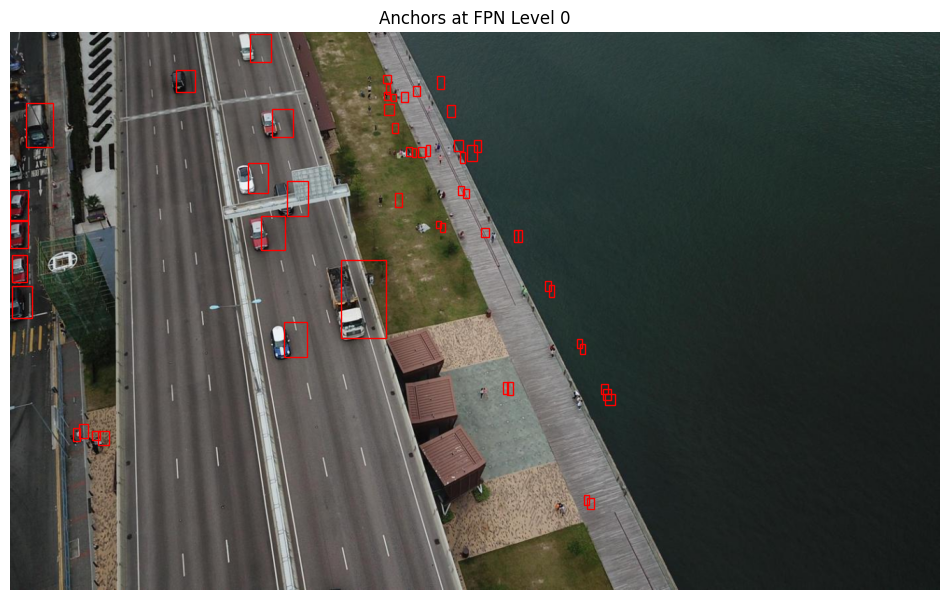

In [94]:
def plot_anchors_on_image(image_tensor, anchors, num_to_plot=100, title="Anchors", color="red"):
    """
    Plots anchor boxes on an image.

    Args:
        image_tensor (Tensor): shape (3, H, W)
        anchors (Tensor): shape (N, 4), format (x1, y1, x2, y2)
        num_to_plot (int): number of anchor boxes to plot
        title (str): title of the plot
        color (str): color of anchor boxes
    """
    image = TF.to_pil_image(image_tensor.cpu())
    anchors_np = anchors.cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    ax.set_title(title)

    for i in range(min(num_to_plot, len(anchors_np))):
        x1, y1, x2, y2 = anchors_np[i]
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=1,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

plot_anchors_on_image(images[0], targets["boxes"][0], num_to_plot=100, title="Anchors at FPN Level 0")

# Implemeting Detection loss

In [105]:
# first we need to match our anchor boxes to our ground_truth bboxes

class MatchAnchorToGt(nn.Module):
    def __init__(self, iou_threshold=0.5):
        super(MatchAnchorToGt, self).__init__()
        self.iou_threshold = iou_threshold

    def forward(self, anchors, gt_boxes):
        """
        Match anchors to GT boxes using max IoU.
        
        Args:
            anchors (Tensor[N, 4]): Anchors
            gt_boxes (Tensor[M, 4]): Ground-truth boxes
    
        Returns:
            matches (Tensor[N]): index of matched GT box, or -1 for background
            ious (Tensor[N]): IoU scores of matched GT boxes
        """

        N = anchors.size(0)
        M = gt_boxes.size(0)

        iou_matrix = ops.box_iou(anchors, gt_boxes)

        # max IoU for each anchor
        max_iou, max_idx = iou_matrix.max(dim=1) # both shape [N]

        # assign match only if IoU > threshold
        matches = max_idx.clone()
        matches[max_iou < self.iou_threshold] = -1  # mark unmatched as -1
        return matches, max_iou

match_anchor_to_gt = MatchAnchorToGt(iou_threshold=0.2)


anchors_cat = torch.concat(anchors, dim=0)
print(f"{anchors_cat.size() = }")

matches, max_iou = match_anchor_to_gt(anchors_cat, targets["boxes"][0])
print(f"{matches.unique()}")
print(f"{max_iou.unique()}")

temp = matches.detach().numpy().copy() + 1
print(f"{np.bincount(temp)}")
print(f"{max_iou.max()}")
print(f"{max_iou.min()}")

anchors_cat.size() = torch.Size([89023, 4])
tensor([-1,  0])
tensor([0.0000e+00, 1.4884e-05, 4.5742e-05,  ..., 4.2248e-01, 4.2802e-01,
        4.3359e-01])
[88287   736]
0.43359375
0.0


In [112]:
# I think I need to take our bounding boxes and rescale them based on our anchors

print(f"{targets['boxes'][0][0]}")
gt_bbox = targets['boxes'][0][0].unsqueeze(0)
fake_anchor = torch.tensor([[450., 327., 538., 438.]])  # roughly around GT box
iou = ops.box_iou(fake_anchor, gt_bbox)
print("IoU with fake anchor:", iou.item())
gt_bbox.size()

tensor([474., 327., 538., 438.])
IoU with fake anchor: 0.7272727489471436


torch.Size([1, 4])

In [114]:
class ATSSMatcher:
    def __init__(self, top_k=9):
        self.top_k = top_k  # number of anchors to select per level

    def __call__(self, anchors_per_level, gt_boxes):
        """
        anchors_per_level: List[Tensor[N_i, 4]] in (x1, y1, x2, y2) format
        gt_boxes: Tensor[M, 4]
        Returns:
            matched_idxs: Tensor[N_total] with GT index or -1
            max_ious: Tensor[N_total]
        """
        num_gt = gt_boxes.size(0)
        all_anchors = torch.cat(anchors_per_level, dim=0)  # [N_total, 4]
        num_anchors = all_anchors.size(0)

        matched_idxs = torch.full((num_anchors,), -1, dtype=torch.long, device=gt_boxes.device)
        max_ious = torch.zeros(num_anchors, dtype=torch.float, device=gt_boxes.device)

        # 1. Compute IoU between all anchors and GTs
        ious = ops.box_iou(all_anchors, gt_boxes)  # [N_total, M]

        # 2. Compute anchor centers
        anchor_centers = (all_anchors[:, :2] + all_anchors[:, 2:]) / 2  # [N, 2]
        gt_centers = (gt_boxes[:, :2] + gt_boxes[:, 2:]) / 2  # [M, 2]

        for gt_idx in range(num_gt):
            gt_box = gt_boxes[gt_idx]
            gt_center = gt_centers[gt_idx]  # [2]

            # Distance from GT center to anchor centers
            distances = torch.norm(anchor_centers - gt_center[None, :], dim=1)  # [N]

            # Pick top-k closest anchors
            topk_idxs = torch.topk(distances, self.top_k, largest=False).indices  # [top_k]

            topk_ious = ious[topk_idxs, gt_idx]
            iou_mean = topk_ious.mean()
            iou_std = topk_ious.std()
            dynamic_thresh = iou_mean + iou_std

            # Positive = anchors with IoU >= dynamic_thresh and inside GT
            candidate_mask = ious[:, gt_idx] >= dynamic_thresh

            inside_gt = self.anchor_inside_box(all_anchors, gt_box)
            pos_mask = candidate_mask & inside_gt  # [N]

            pos_indices = pos_mask.nonzero(as_tuple=False).squeeze(1)
            matched_idxs[pos_indices] = gt_idx
            max_ious[pos_indices] = ious[pos_indices, gt_idx]

        return matched_idxs, max_ious

    def anchor_inside_box(self, anchors, gt_box):
        """
        Return a mask of anchors whose center is inside the GT box.
        """
        cx = (anchors[:, 0] + anchors[:, 2]) / 2
        cy = (anchors[:, 1] + anchors[:, 3]) / 2

        return (
            (cx >= gt_box[0]) & (cx <= gt_box[2]) &
            (cy >= gt_box[1]) & (cy <= gt_box[3])
        )

In [115]:
matcher = ATSSMatcher(top_k=9)
matched_idxs, ious = matcher(anchors, targets["boxes"][0])  # for image i

In [117]:
matched_idxs.unique()

tensor([-1])

tensor([0., 0., 0.,  ..., 0., 0., 0.])